In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


In [2]:
import theano
import theano.tensor.signal.downsample
from theano.tensor.shared_randomstreams import RandomStreams
import time

Using gpu device 0: GeForce GTX 780 (CNMeM is enabled)


In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))

cifar10_train = CIFAR10(("train",), subset=slice(None, 40000))
#this stream will shuffle the CIFAR10 set and return us batches of 25 examples
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 25))
                                               
cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))

# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 100))
cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test, iteration_scheme=SequentialScheme(cifar10_test.num_examples, 100))

In [4]:
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (25, 3, 32, 32) containing float32
 - an array of size (25, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [5]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [6]:
##################################################
#   BUILDING A COMPUTATIONAL GRAPH WITH THEANO   #
##################################################

X = theano.tensor.tensor4('X')
Y = theano.tensor.matrix('Y', dtype='uint8')

model_parameters = []


# CONVOLUTIONAL LAYER 1

#The shape is: num_out_filters x num_in_filters x filter_height x filter_width
num_filters_1 = 40
CW1 = theano.shared(np.zeros((num_filters_1,3,3,3), dtype='float32'), name='CW1')
CW1.tag.initializer = IsotropicGaussian(0.01)

CB1 = theano.shared(np.zeros((num_filters_1,), dtype='float32'), name='CB1')
CB1.tag.initializer = Constant(0.0)
model_parameters += [CW1, CB1]

conv1 = theano.tensor.nnet.conv2d(X, CW1) + CB1.dimshuffle('x',0,'x','x')
after_C1 = theano.tensor.maximum(0.0, conv1)
after_P1 = theano.tensor.signal.downsample.max_pool_2d(after_C1, (3,3), ignore_border=True)


# CONVOLUTIONAL LAYER 2

num_filters_2 = 50
CW2 = theano.shared(np.zeros((num_filters_2,num_filters_1,3,3), dtype='float32'), name='CW2')
CW2.tag.initializer = IsotropicGaussian(0.01)

CB2 = theano.shared(np.zeros((num_filters_2,), dtype='float32'), name='CB2')
CB2.tag.initializer = Constant(0.0)
model_parameters += [CW2, CB2]

conv2 = theano.tensor.nnet.conv2d(after_P1, CW2) + CB2.dimshuffle('x',0,'x','x')
after_C2 = theano.tensor.maximum(0.0, conv2)
after_P2 = theano.tensor.signal.downsample.max_pool_2d(after_C2, (2,2), ignore_border=True)


# FULLY CONNECTED LAYER 1

num_fw3_hidden = 500
FW3 = theano.shared(np.zeros((num_filters_2 * 16, num_fw3_hidden), dtype='float32'), name='FW3')
FW3.tag.initializer = IsotropicGaussian(0.01)

FB3 = theano.shared(np.zeros((num_fw3_hidden,), dtype='float32'), name='FB3')
FB3.tag.initializer = Constant(0.0)
model_parameters += [FW3, FB3]

dot3 = theano.tensor.dot(after_P2.flatten(2), FW3) + FB3.dimshuffle('x',0)
after_F3 = theano.tensor.maximum(0.0, dot3)


# FULLY CONNECTED LAYER 2

num_fw4_hidden = 10
FW4 = theano.shared(np.zeros((num_fw3_hidden, num_fw4_hidden), dtype='float32'), name='FW4')
FW4.tag.initializer = IsotropicGaussian(0.01)

FB4 = theano.shared(np.zeros((num_fw4_hidden,), dtype='float32'), name='FB4')
FB4.tag.initializer = Constant(0.0)
model_parameters += [FW4, FB4]

after_F4 = theano.tensor.dot(after_F3, FW4) + FB4.dimshuffle('x',0)


# COMPUTING PREDICTIONS

log_probs = theano.tensor.nnet.softmax(after_F4)
predictions = theano.tensor.argmax(log_probs, axis=1)

predict = theano.function([X], predictions)


# DROPOUT

aff_layers = [after_F3]
conv_layers = [after_C1, after_C2]

rng = RandomStreams()
dropout = True

input_drop = 0.
conv_drop = 0.
aff_drop = 0.5

if dropout:
    
    if input_drop > 0.:
        mask = rng.uniform((X.shape[0],)) >= input_drop
        mask /= (1.0 - input_drop)
        mask = mask.dimshuffle(0,'x','x','x')
        new_X = X*mask
        log_probs = theano.clone(log_probs, replace=[(X, new_X)])
        predictions = theano.clone(predictions, replace=[(X, new_X)])
    
    if conv_drop > 0.:
        for cl in conv_layers:
            mask = rng.uniform((cl.shape[1],)) >= conv_drop
            mask = mask.dimshuffle('x',0,'x','x')
            mask /= (1.0 - conv_drop)
            new_cl = cl*mask
            log_probs = theano.clone(log_probs, replace=[(cl, new_cl)])
            predictions = theano.clone(predictions, replace=[(cl, new_cl)])
        
    if aff_drop > 0.:
        for al in aff_layers:
            mask = rng.uniform((al.shape[1],)) >= aff_drop
            mask = mask.dimshuffle('x',0)
            mask /= (1.0 - aff_drop)
            new_al = al*mask
            log_probs = theano.clone(log_probs, replace=[(al, new_al)])
            predictions = theano.clone(predictions, replace=[(al, new_al)])


    
# CALCULATING THE COST
    
error_rate = theano.tensor.neq(predictions, Y.ravel()).mean()
nll = -theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()    

weight_decay = 0.0
for p in model_parameters:
    if p.name[1] == 'W':
        weight_decay += 1e-3 * (p**2).sum()

cost = nll + weight_decay


updates = []

lrate = theano.tensor.scalar('lrate',dtype='float32')
momentum = theano.tensor.scalar('momentum',dtype='float32')

gradients = theano.grad(cost, model_parameters)

velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in model_parameters]

for p,g,v in zip(model_parameters, gradients, velocities):
    v_new = momentum*v - lrate*g
    p_new = p + v_new
    updates += [(v,v_new), (p,p_new)]


# MAKING A TRAIN FUNCTION

train_step = theano.function([X,Y,lrate,momentum],[cost, error_rate, nll, weight_decay],updates=updates)

In [7]:
def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples

In [8]:
#utilities to save values of parameters and to load them

def init_parameters():
    rng = np.random.RandomState(1234)
    for p in model_parameters:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in model_parameters]

def load_parameters(snapshot):
    for p, s in zip(model_parameters, snapshot):
        p.set_value(s, borrow=False)
        
def duplicate_data_shift(batch_X, n, k):
    res = batch_X
    for i in range(n):
        new_data = np.copy(batch_X)
        for i in range(new_data.shape[0]):
            new_data[i] = np.roll(new_data[i], np.random.randint(-k,k+1), axis=1)
            new_data[i] = np.roll(new_data[i], np.random.randint(-k,k+1), axis=2)
        res = np.vstack((res, new_data))
    return res

def duplicate_data_flip(batch_X, n):
    res = batch_X
    for i in range(n):
        new_data = np.copy(batch_X)
        for i in range(new_data.shape[0]):
            for j in range(new_data.shape[1]):
                new_data[i][j] = np.fliplr(new_data[i][j])
        res = np.vstack((res, new_data))
    return res

def noise_batch(X_batch, k):
    new_data = X_batch
    for i in range(new_data.shape[0]):
        choice = np.random.uniform()
        if choice < 0.3:
            for j in range(new_data.shape[1]):
                new_data[i][j] = np.fliplr(new_data[i][j])
        elif choice < 0.6:
            new_data[i] = np.roll(new_data[i], np.random.randint(-k,k+1), axis=1)
            new_data[i] = np.roll(new_data[i], np.random.randint(-k,k+1), axis=2)
    return new_data

In [9]:
# init training

i = 0
e = 0

init_parameters()
for v in velocities:
    v.set_value(np.zeros_like(v.get_value()))

best_valid_error_rate = np.inf
best_params = snapshot_parameters()
best_params_epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5

In [10]:
# training loop
t = time.time()

while e < number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    for X_batch, Y_batch in cifar10_train_stream.get_epoch_iterator(): 
        i += 1
        
        K = 5000
        lrate = 1e-2 * K / np.maximum(K, i)
        
        momentum = 0.9
        
        repeats = 1
        shift_range = 4
        
        #new_X_batch = duplicate_data_flip(X_batch, repeats, shift_range)
        #new_Y_batch = np.tile(Y_batch, (repeats+1, 1))
        
        L, err_rate, nll, wdec = train_step(noise_batch(X_batch, shift_range), Y_batch, lrate, momentum)        
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
        
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(cifar10_validation_stream)
    if val_error_rate < best_valid_error_rate:
        number_of_epochs = np.maximum(number_of_epochs, e*patience_expansion + 1)
        best_valid_error_rate = val_error_rate
        best_params = snapshot_parameters()
        best_params_epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))
    
print "Learning time: ", time.time() - t, " seconds"

At minibatch 100, batch loss 2.336822, batch nll 2.295803, batch error rate 72.000000%
At minibatch 200, batch loss 2.341285, batch nll 2.301869, batch error rate 88.000000%
At minibatch 300, batch loss 2.351443, batch nll 2.313558, batch error rate 92.000000%
At minibatch 400, batch loss 2.345406, batch nll 2.308977, batch error rate 100.000000%
At minibatch 500, batch loss 2.333919, batch nll 2.298846, batch error rate 88.000000%
At minibatch 600, batch loss 2.342458, batch nll 2.308495, batch error rate 100.000000%
At minibatch 700, batch loss 2.241091, batch nll 2.205837, batch error rate 68.000000%
At minibatch 800, batch loss 2.278525, batch nll 2.241440, batch error rate 88.000000%
At minibatch 900, batch loss 2.228145, batch nll 2.189721, batch error rate 80.000000%
At minibatch 1000, batch loss 1.874870, batch nll 1.834358, batch error rate 76.000000%
At minibatch 1100, batch loss 2.111114, batch nll 2.068082, batch error rate 76.000000%
At minibatch 1200, batch loss 1.854317,

KeyboardInterrupt: 

In [11]:
print "Learning time: ", time.time() - t, " seconds"

Learning time:  9931.86464  seconds


Setting network parameters from after epoch 168
Test error rate is 18.830000%
Train error rate is 8.257500%


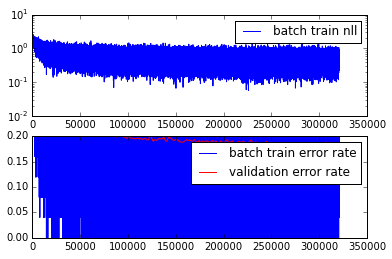

In [12]:
print "Setting network parameters from after epoch %d" %(best_params_epoch)
load_parameters(best_params)

print "Test error rate is %f%%" %(compute_error_rate(cifar10_test_stream)*100.0,)
print "Train error rate is %f%%" %(compute_error_rate(cifar10_train_stream)*100.0,)

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
ylim(0,0.2)
legend()

In [14]:
def log_test_results():
    test_Y = array([], dtype=int)
    predicted_Y = array([], dtype=int)
    for X, Y in cifar10_test_stream.get_epoch_iterator():
        predicted_Y = append(predicted_Y, predict(X).ravel())
        test_Y = append(test_Y, Y.ravel())
            
    with open('test_results', 'w') as f:
        for i in range(test_Y.shape[0]):
            f.write("%d %d\n" % (predicted_Y[i], test_Y[i]))
            
log_test_results()